In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('all_seasons.csv')

In [4]:
le = LabelEncoder()
df['team_encoded'] = le.fit_transform(df['team_abbreviation'])
df['college_encoded'] = le.fit_transform(df['college'].fillna('None'))
df['country_encoded'] = le.fit_transform(df['country'])

In [5]:
# Sélection des features
features = ['age', 'player_height', 'player_weight', 'team_encoded', 
           'college_encoded', 'country_encoded', 'gp', 'reb', 'ast',
           'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']

X = df[features]
y = df['pts']  # Prédiction des points marqués

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# 1. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Prédictions Random Forest
rf_predictions = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Performance:")
print(f"MSE: {rf_mse:.2f}")
print(f"R2 Score: {rf_r2:.2f}")


Random Forest Performance:
MSE: 1.14
R2 Score: 0.97


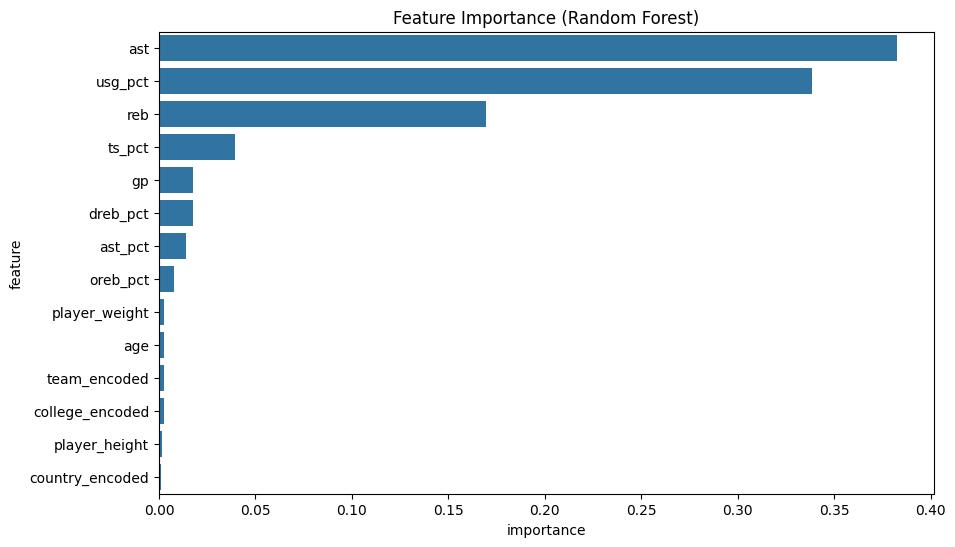

In [9]:
# Feature importance plot
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.show()

In [10]:
# 2. Deep Neural Network
def create_dnn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

# Création et compilation du modèle DNN
dnn_model = create_dnn_model(X_train_scaled.shape[1])
dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/anaconda3/envs/LLM_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Entraînement du modèle avec early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = dnn_model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Évaluation du DNN
dnn_predictions = dnn_model.predict(X_test_scaled)
dnn_mse = mean_squared_error(y_test, dnn_predictions)
dnn_r2 = r2_score(y_test, dnn_predictions)

print("\nDeep Neural Network Performance:")
print(f"MSE: {dnn_mse:.2f}")
print(f"R2 Score: {dnn_r2:.2f}")


Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 42.4998 - mae: 4.5909 - val_loss: 5.5396 - val_mae: 1.4894
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 7.5845 - mae: 1.8308 - val_loss: 3.8729 - val_mae: 1.2382
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 4.9991 - mae: 1.5330 - val_loss: 2.0577 - val_mae: 0.8675
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 3.8886 - mae: 1.3571 - val_loss: 1.5544 - val_mae: 0.7590
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 3.3803 - mae: 1.2508 - val_loss: 1.4303 - val_mae: 0.7473
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 3.1433 - mae: 1.2070 - val_loss: 1.1618 - val_mae: 0.6892
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 2.7104 - mae: 1.1161 - val_loss: 0.9888 - val_mae: 0.6358
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 2.3583 - mae: 1.0594 - val_loss: 0.8662 - val_mae: 0.5962
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━

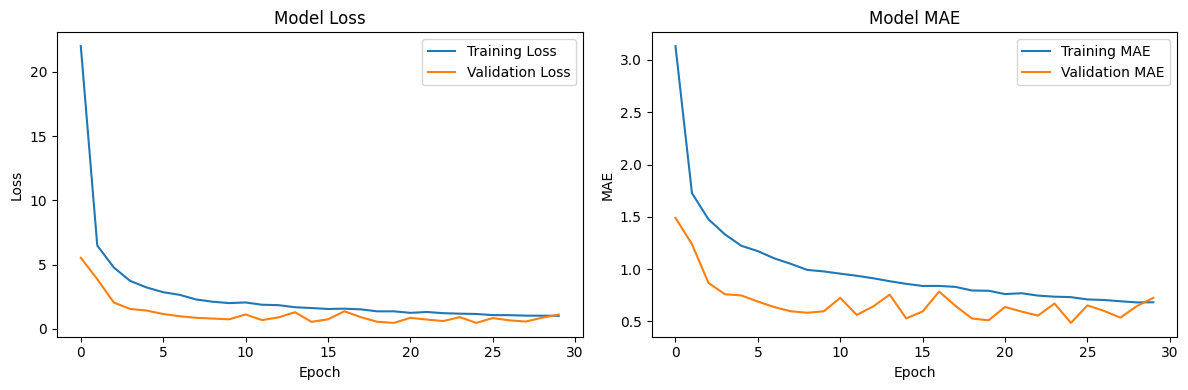

In [12]:

# Plot de l'historique d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()




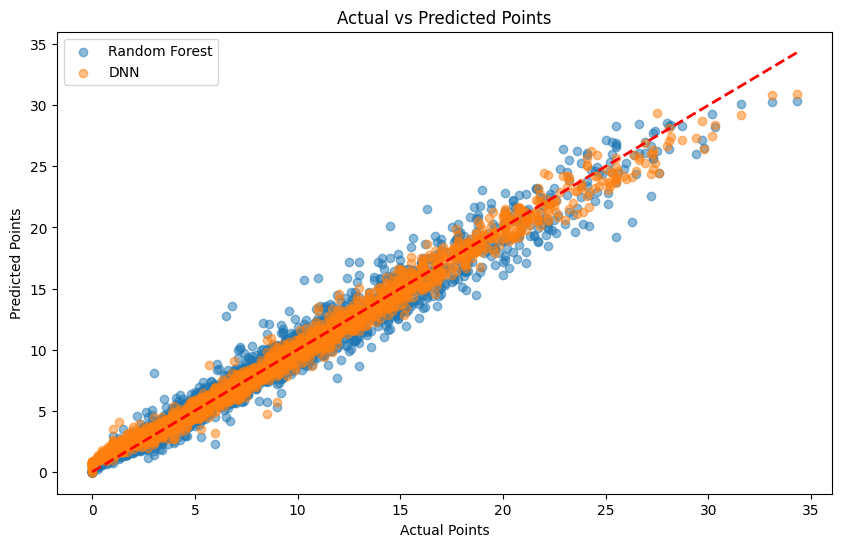

In [13]:
# Comparaison des prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.5, label='Random Forest')
plt.scatter(y_test, dnn_predictions, alpha=0.5, label='DNN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted Points')
plt.legend()
plt.show()

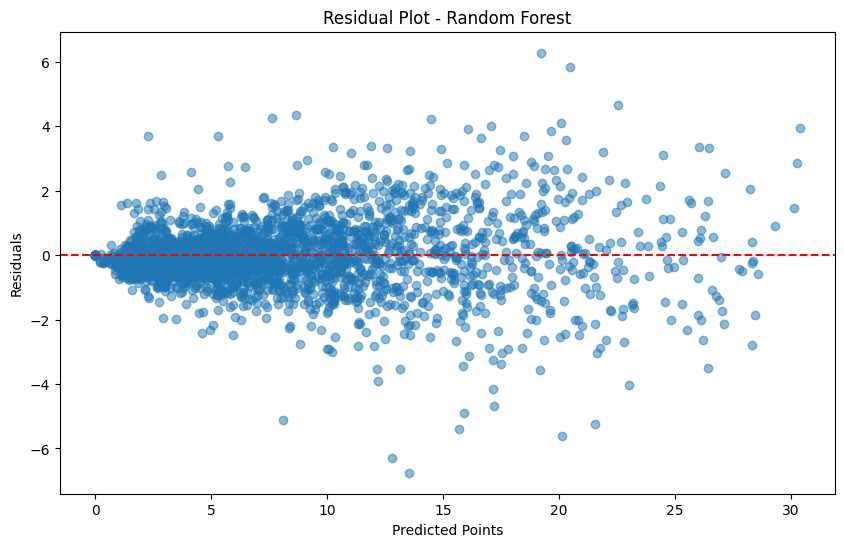

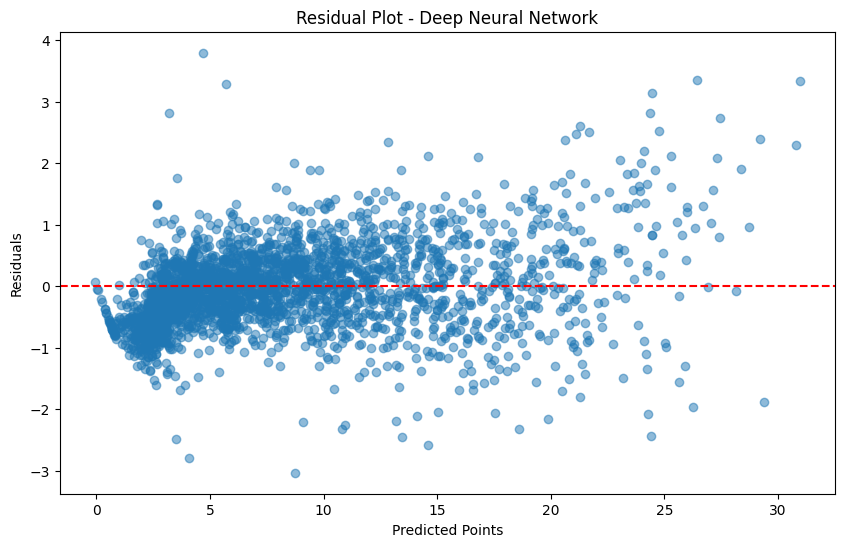

In [14]:
# Analyse des résidus
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred.flatten()
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred.flatten(), residuals, alpha=0.5)
    plt.xlabel('Predicted Points')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

plot_residuals(y_test, rf_predictions, 'Random Forest')
plot_residuals(y_test, dnn_predictions, 'Deep Neural Network')

In [15]:
# Dans votre notebook après l'entraînement
import joblib
import os

joblib.dump(dnn_model, 'dnn_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Vérifier que les fichiers ont été créés
print("Fichiers créés:", os.listdir())

Fichiers créés: ['main.ipynb', 'interface.py', 'm.joblib', 'scaler.joblib', 'README.md', '.gitignore', 'gb_model.joblib', '.gitattributes', 'dnn_model.joblib', 'all_seasons.csv', '.git']


In [66]:
import random

# Sélectionner un joueur aléatoire dans l'ensemble de test
random_index = random.randint(0, len(X_test) - 1)
player_features = X_test_scaled[random_index].reshape(1, -1)
real_points = y_test.iloc[random_index]

# Faire les prédictions
dnn_prediction = dnn_model.predict(player_features)[0][0]
rf_prediction = rf_model.predict(player_features)[0]

# Récupérer le nom du joueur correspondant
player_name = df.iloc[X_test.index[random_index]]['player_name']
player_season = df.iloc[X_test.index[random_index]]['season']

# Afficher les résultats
print(f"Joueur: {player_name} ({player_season})")
print(f"Points réels: {real_points:.2f}")
print(f"Prédiction DNN: {dnn_prediction:.2f}")
print(f"Prédiction RF: {rf_prediction:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Joueur: Sherman Douglas (1999-00)
Points réels: 6.00
Prédiction DNN: 5.80
Prédiction RF: 6.90
